<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [AE4] - Building and training an AE denoiser model
<!-- DESC --> Episode 1 : After construction, the model is trained with noisy data from the MNIST dataset.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a denoizing **autoencoder** neurals network (AE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST.  
The use of a GPU is often indispensable.

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Follow the learning process with Tensorboard

## Step 1 - Init python stuff
### 1.1 - Init

In [3]:
import numpy as np
from skimage import io

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from modules.callbacks          import ImagesCallback
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard

import os,sys
from importlib import reload
import h5py

from modules.MNIST     import MNIST
from modules.callbacks import ImagesCallback, BestModelCallback

sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/AE4'
datasets_dir = pwk.init('AE4', run_dir)

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.19
Notebook id          : AE4
Run time             : Sunday 14 March 2021, 09:59:18
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/AE4
Update keras cache   : False


### 1.2 - Parameters
`prepared_dataset` : Filename of the prepared dataset (Need 400 Mo, but can be in ./data)  
`dataset_seed` : Random seed for shuffling dataset  
`scale` : % of the dataset to use (1. for 100%)  
`latent_dim` : Dimension of the latent space  
`train_prop` : Percentage for train (the rest being for the test)
`batch_size` : Batch size  
`epochs` : Nb of epochs for training


In [4]:
prepared_dataset = './data/mnist-noisy.h5'
dataset_seed     = 123

scale            = .1

latent_dim       = 10

train_prop       = .8
batch_size       = 128
epochs           = 30

Override parameters (batch mode) - Just forget this cell

In [5]:
pwk.override('prepared_dataset', 'dataset_seed', 'scale', 'latent_dim')
pwk.override('train_prop', 'batch_size', 'epochs')

## Step 2 - Retrieve dataset
With our MNIST class, in one call, we can reload, rescale, shuffle and split our previously saved dataset :-)

In [21]:
clean_train,clean_test, noisy_train,noisy_test, class_train,class_test = MNIST.reload_prepared_dataset(scale      = scale, 
                                                                                    train_prop = train_prop,
                                                                                    seed       = dataset_seed,
                                                                                    shuffle    = True,
                                                                                    filename=prepared_dataset )

Loaded.
rescaled (0.1).
Seeded (123)
Shuffled.
splited (0.8).
clean_train shape is :  (5600, 28, 28, 1)
clean_test  shape is :  (1400, 28, 28, 1)
noisy_train shape is :  (5600, 28, 28, 1)
noisy_test  shape is :  (1400, 28, 28, 1)
class_train shape is :  (5600,)
class_test  shape is :  (1400,)
Blake2b digest is    :  32086fb6b2d76baafae3


## Step 3 - Build model

#### Encoder

In [7]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(inputs)
x         = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)
z         = layers.Dense(latent_dim)(x)

encoder = keras.Model(inputs, z, name="encoder")
# encoder.summary()

#### Decoder

In [8]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x       = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(inputs, outputs, name="decoder")
# decoder.summary()

#### AE


In [9]:
inputs    = keras.Input(shape=(28, 28, 1))

latents   = encoder(inputs)
outputs   = decoder(latents)

ae = keras.Model(inputs,outputs, name='ae')

#### CNN

In [11]:
hidden1     = 100
hidden2     = 100

inputs    = keras.Input(shape=(28, 28, 1))

x         = keras.layers.Conv2D(8, (3,3),  activation='relu')(inputs)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Conv2D(16, (3,3), activation='relu')(x)
x         = keras.layers.MaxPooling2D((2,2))(x)
x         = keras.layers.Dropout(0.2)(x)

x         = keras.layers.Flatten()(x)
x         = keras.layers.Dense(100, activation='relu')(x)
x         = keras.layers.Dropout(0.5)(x)

outputs   = keras.layers.Dense(10, activation='softmax')(x)

cnn       = keras.Model(inputs, outputs, name='cnn')

#### Final model

In [27]:
inputs    = keras.Input(shape=(28, 28, 1))

denoised = ae(inputs)
classcat = cnn(inputs)

model = keras.Model(inputs, [denoised, classcat])

model.compile(optimizer='rmsprop', 
              loss=['binary_crossentropy', 'sparse_categorical_crossentropy'],
              loss_weights=[1,1],
              metrics={'cnn':'accuracy'} )

## Step 4 - Train
20' on a CPU  
1'12 on a GPU (V100, IDRIS)

In [28]:
# ---- Callback : Images
#
pwk.mkdir( run_dir + '/images')
filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'
callback_images = ImagesCallback(filename, x=clean_test[:5], encoder=encoder,decoder=decoder)

# ---- Callback : Best model
#
pwk.mkdir( run_dir + '/models')
filename = run_dir + '/models/best_model.h5'
callback_bestmodel = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

# ---- Callback tensorboard
#
logdir = run_dir + '/logs'
callback_tensorboard = TensorBoard(log_dir=logdir, histogram_freq=1)

# callbacks_list = [callback_images, callback_bestmodel, callback_tensorboard]
callbacks_list = [callback_images, callback_bestmodel]

In [29]:
pwk.chrono_start()

history = model.fit(noisy_train, [clean_train, class_train],
                 batch_size      = batch_size,
                 epochs          = epochs,
                 verbose         = 1,
                 validation_data = (noisy_test, [clean_test, class_test]),
                 callbacks       = callbacks_list  )

pwk.chrono_show()

Epoch 1/30
44/44 [==============================] - 3s 68ms/step - loss: 0.8241 - ae_loss: 0.1573 - cnn_loss: 0.6668 - cnn_accuracy: 0.7812 - val_loss: 0.7687 - val_ae_loss: 0.1761 - val_cnn_loss: 0.5926 - val_cnn_accuracy: 0.8043
Epoch 2/30
44/44 [==============================] - 3s 65ms/step - loss: 0.8104 - ae_loss: 0.1541 - cnn_loss: 0.6563 - cnn_accuracy: 0.7877 - val_loss: 0.7619 - val_ae_loss: 0.1739 - val_cnn_loss: 0.5880 - val_cnn_accuracy: 0.8064
Epoch 3/30
44/44 [==============================] - 4s 84ms/step - loss: 0.7915 - ae_loss: 0.1534 - cnn_loss: 0.6381 - cnn_accuracy: 0.7941 - val_loss: 0.7578 - val_ae_loss: 0.1714 - val_cnn_loss: 0.5864 - val_cnn_accuracy: 0.8079
Epoch 4/30
44/44 [==============================] - 3s 67ms/step - loss: 0.7867 - ae_loss: 0.1521 - cnn_loss: 0.6346 - cnn_accuracy: 0.7873 - val_loss: 0.7551 - val_ae_loss: 0.1741 - val_cnn_loss: 0.5810 - val_cnn_accuracy: 0.8086
Epoch 5/30
44/44 [==============================] - 3s 67ms/step - loss: 0.7

## Step 5 - History

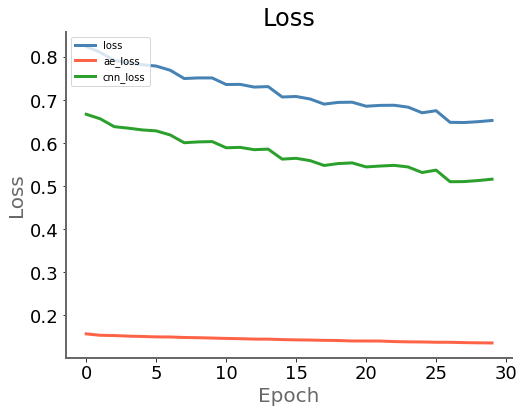

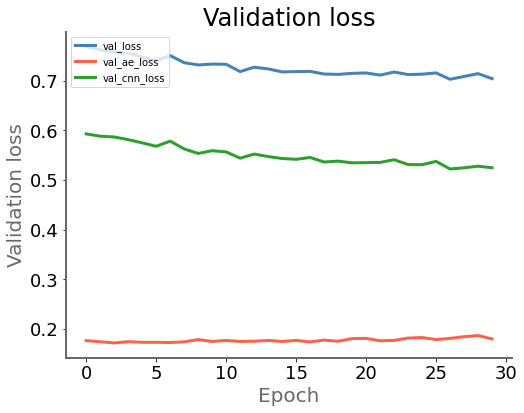

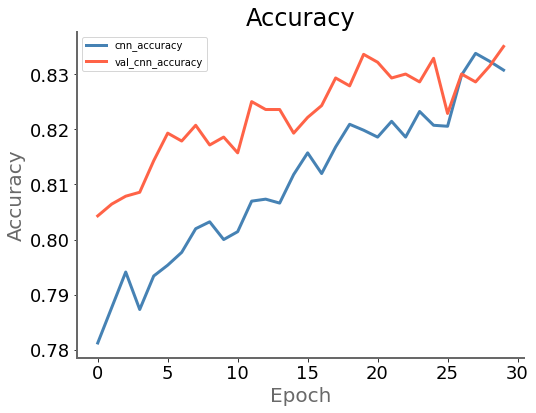

In [33]:
pwk.plot_history(history,  plot={'Loss':['loss', 'ae_loss', 'cnn_loss'],
                                 'Validation loss':['val_loss','val_ae_loss', 'val_cnn_loss'], 
                                 'Accuracy':['cnn_accuracy','val_cnn_accuracy']}, save_as='01-history')

## Step 6 - Have a look
### 6.1 - Denoising progress

<br>**Real images :**

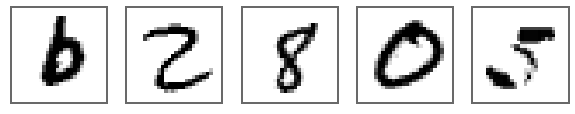

<br>**Noisy images :**

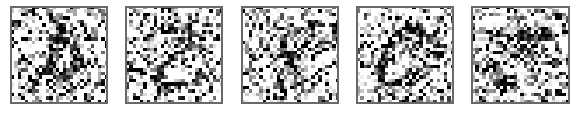

<br>**Learning...**

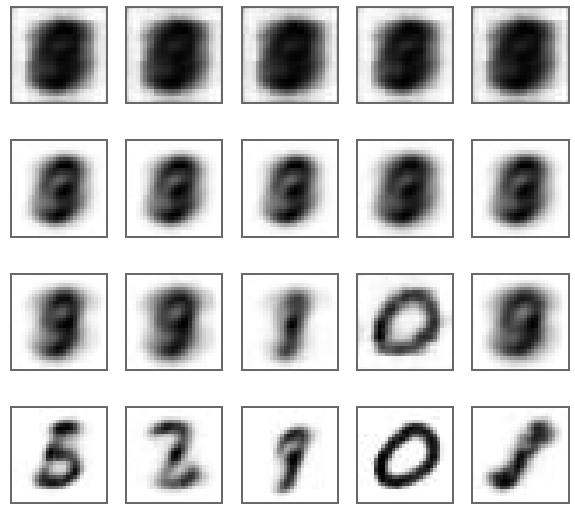

<br>**Noisy images :**

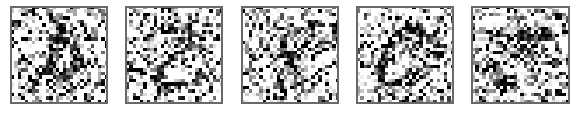

<br>**Real images :**

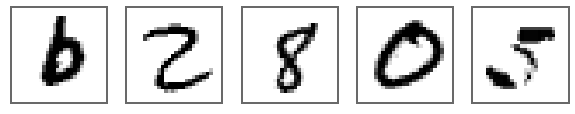

In [50]:
imgs=[]
labels=[]
for epoch in range(0,epochs,4):
    for i in range(5):
        filename = run_dir + '/images/image-{epoch:03d}-{i:02d}.jpg'.format(epoch=epoch, i=i)
        img      = io.imread(filename)
        imgs.append(img)
        

pwk.subtitle('Real images :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='02-original-real')

pwk.subtitle('Noisy images :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='03-original-noisy')

pwk.subtitle('Learning...')
pwk.plot_images(imgs, None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as='04-learning')

pwk.subtitle('Noisy images :')
pwk.plot_images(noisy_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)

pwk.subtitle('Real images :')
pwk.plot_images(clean_test[:5], None, indices='all', columns=5, x_size=2,y_size=2, interpolation=None, save_as=None)


### 6.2 - Classification

<br>**Accuracy :**

Classification accuracy : 0.8371


<br>**Few examples :**

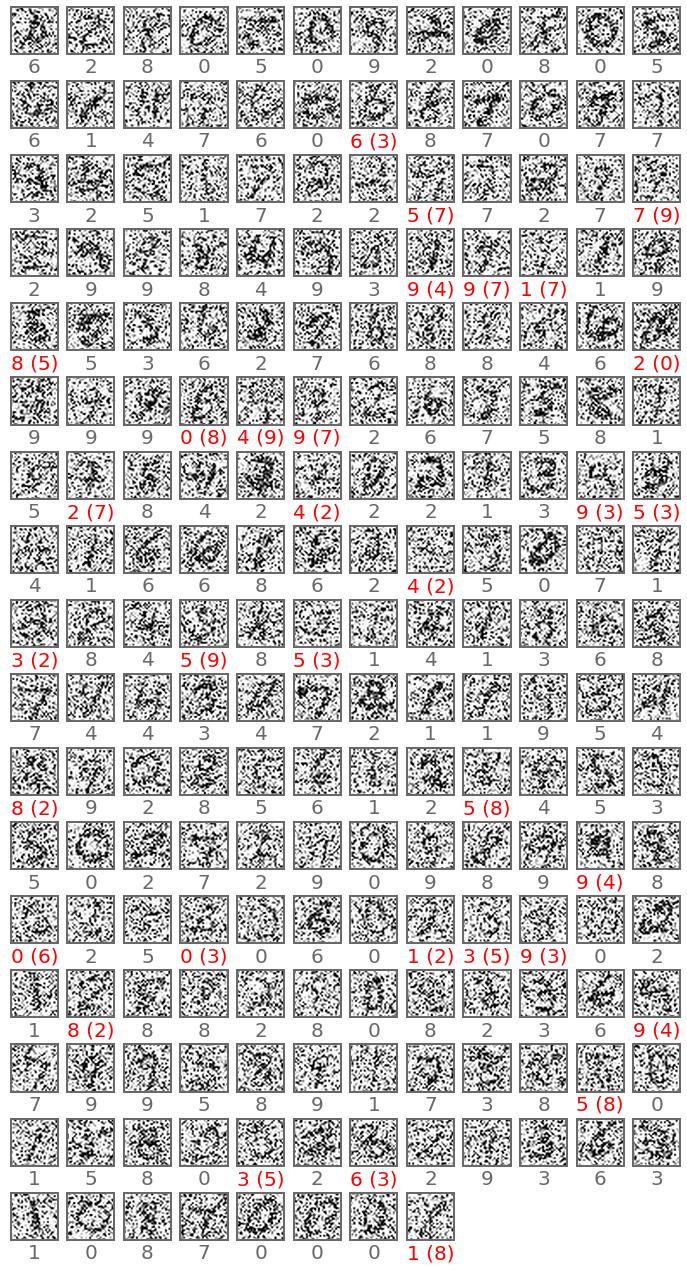

In [61]:
pwk.subtitle("Accuracy :")

score = model.evaluate(noisy_test, [clean_test, class_test], verbose=0)
print(f'Classification accuracy : {score[3]:4.4f}')

pwk.subtitle("Few examples :")

clean_pred, class_sigmoid = model.predict(noisy_test)
class_pred    = np.argmax(class_sigmoid, axis=-1)
pwk.plot_images(noisy_test, class_test, range(0,200), columns=12, x_size=1, y_size=1, y_pred=class_pred, save_as='04-predictions')

In [ ]:
pwk.end()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>